### Importing Libraries and dataset Images

In [ ]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
import pathlib
import datetime
import time

In [ ]:
data_dir='/content/drive/MyDrive/NTU/CE4042/classified_images'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/NTU/CE4042/classified_images')

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

12676

### Prepare Train and Validation data set

In [ ]:
#split data into train and validation dataset
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_dir),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12676 files belonging to 2 classes.
Using 10141 files for training.
Found 12676 files belonging to 2 classes.
Using 2535 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['female_face', 'male_face']


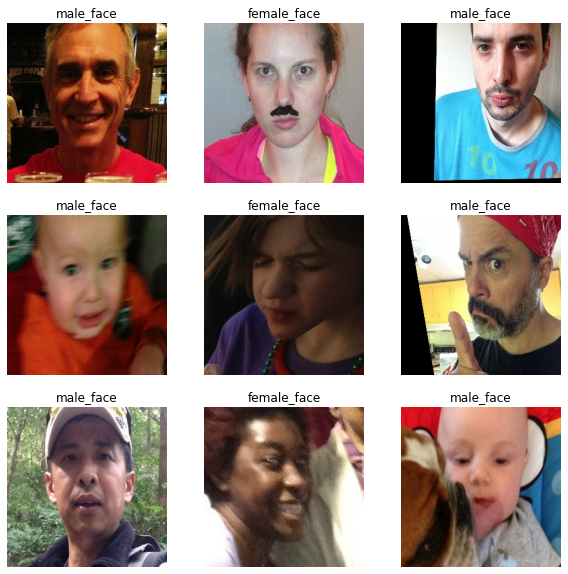

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#normalizing the data to achieve standardization
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


### Inception v3

In [ ]:
#API call to retrieve the inception_v3 layer
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor_model = inception_v3

feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(256, 256, 3),
    trainable=False)

#other models that we experimented with

#inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
#feature_extractor_model = inception_v3

#inception_resnet_v2 = "https://tfhub.dev/google/imagenet/inception_resnet_v2/classification/5"
#feature_extractor_model = inception_resnet_v2

#efficientnet_b7 = "https://tfhub.dev/tensorflow/efficientnet/b7/classification/1"
#feature_extractor_model = efficientnet_b7

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)

#Defining early stopping
def early_stop_callback(name):
  return [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]

#Callback to restore best model weights 
checkpoint_filepath = './best_weights_file'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [ ]:
NUM_EPOCHS = 50
#Fitting the model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=32,
                    epochs=NUM_EPOCHS,
                    callbacks = [early_stop_callback("name"), model_checkpoint_callback])

Epoch 1/50
317/317 [==============================] - ETA: 0s - loss: 0.4111 - acc: 0.8064INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 1605s 5s/step - loss: 0.4111 - acc: 0.8064 - val_loss: 0.3551 - val_acc: 0.8387
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.3464 - acc: 0.8446INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 30s 93ms/step - loss: 0.3464 - acc: 0.8446 - val_loss: 0.3373 - val_acc: 0.8505
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.3256 - acc: 0.8581INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 29s 93ms/step - loss: 0.3256 - acc: 0.8581 - val_loss: 0.3292 - val_acc: 0.8564
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.3119 - acc: 0.8650INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 29s 93ms/step - loss: 0.3119 - acc: 0.8650 - val_loss: 0.3244 - val_acc: 0.8615
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.3015 - acc: 0.8711INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 29s 92ms/step - loss: 0.3015 - acc: 0.8711 - val_loss: 0.3214 - val_acc: 0.8655
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.2932 - acc: 0.8759INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 30s 93ms/step - loss: 0.2932 - acc: 0.8759 - val_loss: 0.3195 - val_acc: 0.8667
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.2863 - acc: 0.8808INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 30s 95ms/step - loss: 0.2863 - acc: 0.8808 - val_loss: 0.3183 - val_acc: 0.8671
Epoch 8/50
317/317 [==============================] - ETA: 0s - loss: 0.2805 - acc: 0.8846INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 30s 94ms/step - loss: 0.2805 - acc: 0.8846 - val_loss: 0.3176 - val_acc: 0.8690
Epoch 9/50
317/317 [==============================] - ETA: 0s - loss: 0.2753 - acc: 0.8871INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 30s 95ms/step - loss: 0.2753 - acc: 0.8871 - val_loss: 0.3173 - val_acc: 0.8686
Epoch 10/50
317/317 [==============================] - ETA: 0s - loss: 0.2708 - acc: 0.8901INFO:tensorflow:Assets written to: ./best_weights_file/assets


INFO:tensorflow:Assets written to: ./best_weights_file/assets


317/317 [==============================] - 30s 94ms/step - loss: 0.2708 - acc: 0.8901 - val_loss: 0.3173 - val_acc: 0.8690
Epoch 11/50
317/317 [==============================] - 22s 71ms/step - loss: 0.2668 - acc: 0.8914 - val_loss: 0.3174 - val_acc: 0.8698
Epoch 12/50
317/317 [==============================] - 22s 71ms/step - loss: 0.2631 - acc: 0.8925 - val_loss: 0.3177 - val_acc: 0.8706
Epoch 13/50
317/317 [==============================] - 22s 71ms/step - loss: 0.2598 - acc: 0.8945 - val_loss: 0.3181 - val_acc: 0.8698
Epoch 14/50
317/317 [==============================] - 22s 70ms/step - loss: 0.2567 - acc: 0.8966 - val_loss: 0.3186 - val_acc: 0.8706
Epoch 15/50
317/317 [==============================] - 22s 71ms/step - loss: 0.2539 - acc: 0.8970 - val_loss: 0.3192 - val_acc: 0.8694
Epoch 16/50
317/317 [==============================] - 23s 71ms/step - loss: 0.2513 - acc: 0.8976 - val_loss: 0.3198 - val_acc: 0.8686
Epoch 17/50
317/317 [==============================] - 23s 71ms/ste

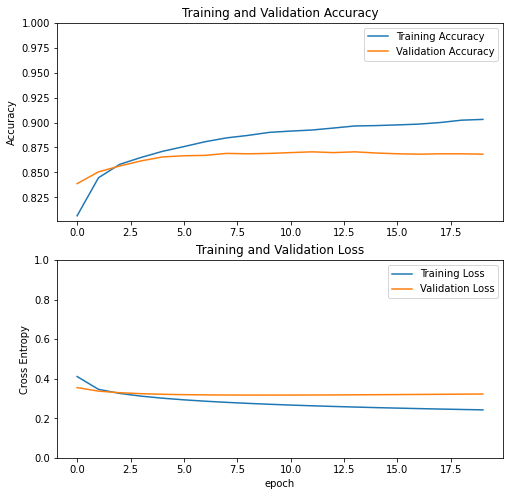

In [ ]:
#plotting the accuracy and the loss 
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model Predictions

In [ ]:
#predicting the gender of the images
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_id
predicted_label_batch=[]
for i in predicted_id.numpy():
    if(i==1):
        predicted_label_batch.append("male")
    else:
        predicted_label_batch.append("female")
print(predicted_label_batch)

['female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'male', 'male', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female']


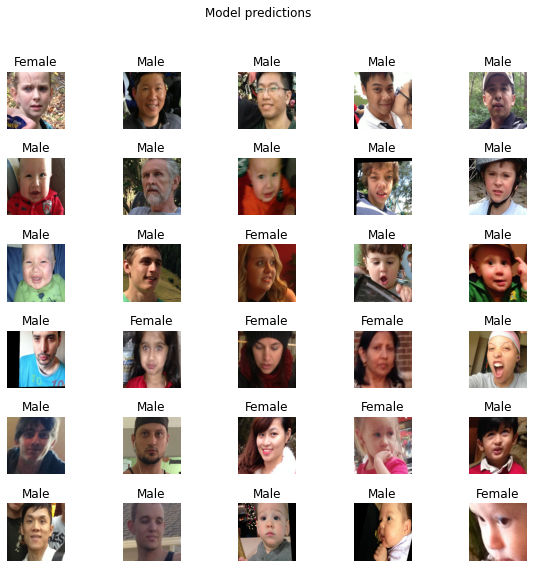

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
t = time.time()
#saving the model to be used later
export_path = "/content/drive/MyDrive/Colab Notebooks/{}".format(int(t))
model.save(export_path)

export_path
#/content/drive/MyDrive/Colab Notebooks/1636788994

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636788994/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/1636788994/assets


'/content/drive/MyDrive/Colab Notebooks/1636788994'